# `在险价值(Value at Risk)风险度量下的资产组合前沿`
---
* ### 对于风险的度量，波动性(volatility)是比较常见的一种方式，但其不足之处在于资产组合价值的正向与方向变化都会增加波动性，而投资者往往不会认为资产组合价值正向变化是一种风险。
  
  
* ### 针对上述情况以及度量不同类型资产组合风险的需要，`VaR风险度量`被提出。其原理非常简单，即最糟糕的情形发生时，资产组合可能受到多大的损失。数学表达如下：

    * ### $\operatorname{Prob}(ΔPΔt≤\operatorname{VaR})=1-\alpha$
    * ### 字母含义如下：

          $\operatorname{Prob}$ —— 资产价值损失小于可能损失上限的概率，即英文的Probability。

          $ΔPΔt$ —— 某一金融资产在一定持有期Δt的价值损失额。

          $VaR$ —— 给定置信水平a下的在险价值，即可能的损失上限。

          $1 - \alpha$ —— 给定的置信水平
    * ### $\alpha$是指风险水平 (1 - 置信水平)，取5%时可以这样理解：有100种可能发生的情况，最坏的5种情况发生时，资产将最低遭到多少的损失。  


* ### 一个直观的解释(来自[wiki - Value at risk](https://en.wikipedia.org/wiki/Value_at_risk#Risk_measure_and_risk_metric))：   <div align = "center">![](http://i4.piimg.com/567571/501d5328c1602fea.jpg)</div>

* ### 计算方法：
    * ### 从公式中可以看出，计算VaR的关键步骤在于估计损失的概率分布情况，基于对分布函数不同的估计方法，对VaR的计算可以分为：
    * ### `历史数据法`：也可以认为是经验分布法，取一段时间的历史数据，考察最糟糕$\alpha$分位数情况下资产组合的损失；
    * ### `方差-协方差方法`：假设损失服从正态分布，从而推算$\alpha$分位点的值；
    * ### `Monte-Carlo`：从经验数据中进行Monte-Carlo模拟抽样，得出所抽到值最差$\alpha$分位点时的值。
  
  
* ### 对于这种风险度量，我们仍然可以考察`资产组合有效前沿`。对于资产组合前沿的介绍即波动性度量下的资产组合前沿构建可以参看[量化分析师的Python日记【第15天：如何在优矿上搞一个wealthfront出来】](https://uqer.io/community/share/5670da3c228e5b8d81f00a87)。

In [ ]:
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as opt 
from CAL.PyCAL import *

fsize = (12, 12*0.618)
DataAPI.settings.cache_enabled = True

python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


* ### 设定研究起止时间，这里是：`2010.01.01 - 2016.08.01`，频率为月度
* ### 设定股票池：`2016.08.01的沪深300成分股`，不设为全A股部分因为优化速度太慢，另外HS300也将满足大部分分散化需求
* ### 获取历史回报率数据

In [ ]:
startDate = '20100101'
endDate = '20160801'
stockPool = set_universe('HS300', endDate)

data = DataAPI.MktEqumGet(secID = stockPool, beginDate= startDate, endDate= endDate,
       field = 'secShortName,endDate,return').pivot(values = 'return', index = 'endDate', columns = 'secShortName')
data.tail()

secShortName,TCL集团,一汽轿车,万华化学,万向钱潮,万科A,万达信息,万达院线,三一重工,三安光电,上汽集团,...,陕西煤业,隧道股份,雅戈尔,青岛啤酒,青岛海尔,鞍钢股份,首创股份,首开股份,鲁信创投,鹏博士
endDate,,,,,,,,,,,,,,,,,,,,,
2016-03-31,0.026810,0.156814,0.144298,0.135007,0.000000,0.081081,0.000000,0.163599,0.089197,0.094381,...,0.004587,0.112011,0.334510,0.081387,0.132353,0.051813,0.168508,0.046826,0.058369,0.235739
2016-04-29,-0.081473,-0.106458,0.106072,-0.086073,0.000000,-0.113971,0.000000,-0.050967,-0.009156,0.013958,...,0.121005,0.106796,0.003968,0.012195,-0.016529,0.022167,-0.040189,0.031809,-0.080292,-0.109750
2016-05-31,-0.011628,0.054011,-0.013648,-0.018637,0.000000,0.019087,0.000000,-0.057407,0.043634,-0.002458,...,-0.097760,-0.053728,0.003294,0.019966,0.098439,-0.067470,0.002506,-0.008671,-0.007055,-0.015873
2016-06-30,-0.032353,-0.180106,0.088050,0.056195,0.000000,0.061090,-0.002321,-0.013752,-0.017708,0.000000,...,0.167043,-0.010004,-0.044834,-0.018900,-0.029508,-0.010336,-0.027500,0.080661,-0.040409,-0.019892
2016-07-29,0.063830,-0.024976,0.104046,-0.055769,-0.269034,-0.118122,-0.107009,0.037849,-0.005850,0.223340,...,0.098646,0.104887,0.100798,0.051037,0.257725,0.070496,0.005141,0.020683,0.005879,0.045254


* ### 采用历史数据经验分布方法估计各只股票VaR值，对于VaR度量有直接认识
* ### 这是因为股票回报率分布往往有厚尾性，正态分布不能准确表达；而Monte-Carlo法与经验分布法结果差距不大

In [ ]:
def histVaR(histSeries, riskLevel = 0.01):
    return -histSeries.describe(percentiles = [riskLevel])[str(int(riskLevel * 100))+'%']

* ### 下图是置信水平(1 - $\alpha$)分别为0.99, 0.95, 0.90时，各只股票的VaR分布情况，置信水平越高表明糟糕程度越甚时在险资金的价值。自然，置信水平越高，VaR值会越大。

* ### `在置信水平0.99情况下，证券VaR = 0.4`是指：最坏1%的情况发生时，该证券将遭到40%以上的损失。

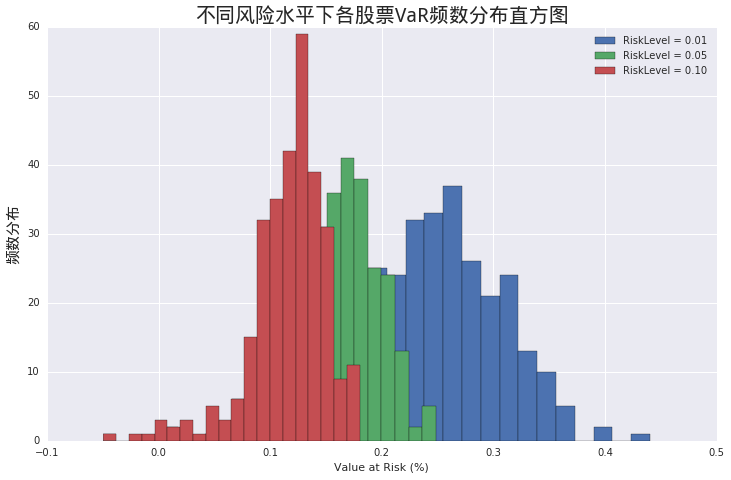

In [ ]:
font.set_size(15)
titleFont = font.copy()
titleFont.set_size(20)
labelFont = font.copy()
labelFont.set_size(12)

fig = plt.figure(figsize = fsize)
pd.Series(map(lambda x: histVaR(data[x], riskLevel= 0.01), data.columns), index = data.columns).hist(label = 'RiskLevel = 0.01', bins = 20)
pd.Series(map(lambda x: histVaR(data[x], riskLevel= 0.05), data.columns), index = data.columns).hist(label = 'RiskLevel = 0.05', bins = 20)
pd.Series(map(lambda x: histVaR(data[x], riskLevel= 0.1), data.columns), index = data.columns).hist(label = 'RiskLevel = 0.10', bins = 20)
plt.legend(loc = 'best')
plt.xlabel('Value at Risk (%)')
plt.ylabel(u"频数分布", fontproperties = font)
_ = plt.title(u"不同风险水平下各股票VaR频数分布直方图", fontproperties = titleFont)

* ### 将$\alpha$设为0.05，考察不同股票组合的有效前沿：即在给定收益率情况下，最小化组合VaR.

In [ ]:
riskLevel = 0.05
def pfVaR(weights):
    return histVaR(pd.DataFrame(np.mat(data.fillna(0))*np.mat(weights).T, columns = ['portVaR']).portVaR, riskLevel= riskLevel)
def pfReturn(weights):
    return (np.mat(data.mean()) * np.mat(weights).T)[0,0]

In [ ]:
wealthFront = []
for retLv in np.arange(0, 0.21, 0.01):
    cons = ({'type': 'eq', 'fun': lambda x: sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: pfReturn(x) - retLv})
    res = opt.minimize(pfVaR, [1/len(stockPool)]*len(stockPool), constraints= cons, 
                   bounds= [(0,1)]*len(stockPool), method = 'SLSQP')
    if res['success'] == True:
        wealthFront += [[retLv, res['fun']]]
        print "Finish minimize VaR for return level %f!"%retLv
    else:
        print "Minimize VaR for return level %f failed!"%retLv
wf = pd.DataFrame(wealthFront, columns = ['expectedReturn', 'VaR'])

Finish minimize VaR for return level 0.000000!


Finish minimize VaR for return level 0.010000!


Finish minimize VaR for return level 0.020000!


Finish minimize VaR for return level 0.030000!


Finish minimize VaR for return level 0.040000!


Finish minimize VaR for return level 0.050000!


Finish minimize VaR for return level 0.060000!


Finish minimize VaR for return level 0.070000!


Finish minimize VaR for return level 0.080000!


Finish minimize VaR for return level 0.090000!


Finish minimize VaR for return level 0.100000!


Finish minimize VaR for return level 0.110000!


Finish minimize VaR for return level 0.120000!


Finish minimize VaR for return level 0.130000!


Finish minimize VaR for return level 0.140000!


Finish minimize VaR for return level 0.150000!


Finish minimize VaR for return level 0.160000!


Finish minimize VaR for return level 0.170000!


Finish minimize VaR for return level 0.180000!


Finish minimize VaR for return level 0.190000!


Finish minimize VaR for return level 0.200000!

* ### 可见，资产组合前沿仍然大致是双曲线右支的形状，全局最小VaR组合的月度收益约在9%  
* ### 当然，由于VaR函数采用一般形式，并不是线性优化/二次优化，算法不是十分有效，有时找不到全局最小值，会使图像上出现一些异常点，如预期收益率为0.15时，所得组合最小VaR过高

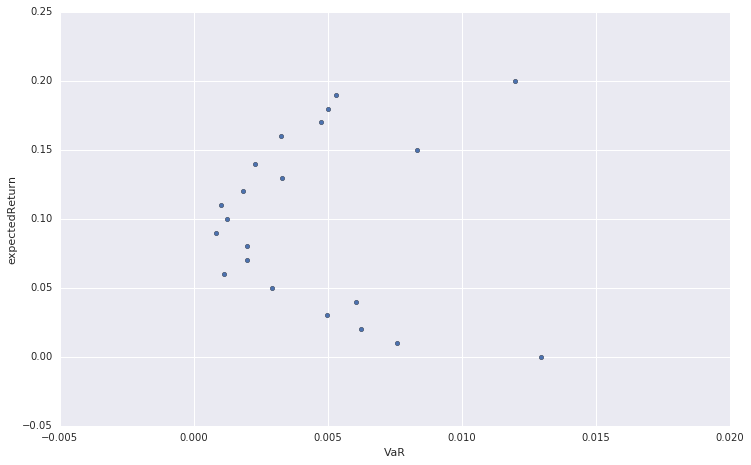

In [ ]:
_ = wf.plot(x= 'VaR', y= 'expectedReturn', kind = 'scatter', figsize = fsize)

In [ ]:
cons = ({'type': 'eq', 'fun': lambda x: sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: pfReturn(x) - 0.09})
res = opt.minimize(pfVaR, [1/len(stockPool)]*len(stockPool), constraints= cons, 
               bounds= [(0,1)]*len(stockPool), method = 'SLSQP')

* ### 值得注意的一点是，VaR不能直接相加，也就是说，股票A、B按一定权重构成的资产组合，其组合VaR不等于股票A的VaR与股票B的VaR的加权和，而必须利用组合的历史回报率经验分布重新估算。
* ### 如50% TCL集团与50%一汽轿车构成的组合，VaR是20.4%，而两只股票VaR加权和是22.0%.
* ### 这是因为两只股票回报率分布不独立，存在相关性，对于资产组合最糟糕的情况不一定对两只股票都最糟糕。

In [ ]:
df = data[data.columns[:2]]
df['组合'] = 0.5 * df[df.columns[0]] + 0.5 * df[df.columns[1]]
for i in range(3):
    print "%s的VaR是%f."%(df.columns[i],histVaR(df[df.columns[i]]))

TCL集团的VaR是0.181631.


一汽轿车的VaR是0.257989.
组合的VaR是0.203551.


* ### 最后，可以大概看一下全局最小VaR组合的成分与权重：

In [ ]:
weights = [_ if abs(_)>0.001 else 0 for _ in res['x']]
wt = pd.DataFrame()
wt['stock'] = data.columns
wt['weights'] = weights
wt = wt[wt.weights>0].set_index('stock')
wt.T
# secDict = DataAPI.EquGet(secID = set_universe('HS300', endDate), field = 'secID,secShortName').set_index('secShortName').secID.to_dict()
# wt.columns = map(lambda x: secDict[x], wt.columns)
# wt = wt.T.weights.to_dict()

stock,万达信息,万达院线,上汽集团,上海莱士,东方证券,中国核电,人民网,国泰君安,恒生电子,招商蛇口,春秋航空,美的集团,节能风电,营口港,陕西煤业
weights,0.003645,0.382867,0.001127,0.001037,0.034009,0.026644,0.001158,0.004859,0.001716,0.176263,0.157516,0.054309,0.007322,0.002074,0.13999


# `总结`
---

* ### 这篇notebook介绍了在线价值(VaR)这一风险度量工具，其特点是定义直观、运用简单、并且具有单向性；
* ### 其不足之处在于：
    * ### 损失的概率分布函数不好确定，利用历史数据有时不能代表未来；
    * ### 不具有直接可加性，运算操作麻烦。
* ### 因而本文只是给出一个想法，说明风险的度量有多种方式，并且在这些方式下，投资者都可以构建相应的资产组合有效前沿。  



  
# `参考资料`
---
* ### [wiki - Value at risk](https://en.wikipedia.org/wiki/Value_at_risk#Risk_measure_and_risk_metric)
* ### [An Introduction To Value at Risk (VAR)](http://www.investopedia.com/articles/04/092904.asp)
* ### [VaR方法](http://wiki.mbalib.com/wiki/VaR%E6%96%B9%E6%B3%95)